In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split

# Suppress the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")


# Load Covertype dataset (7 classes)
covertype = fetch_openml(name='covertype', version=4, as_frame=False)
X, y = covertype.data, covertype.target

# Convert the data to pandas DataFrame to handle NaN values
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

# Drop rows with NaN values in both X and y
X_df_cleaned = X_df.dropna()
y_df_cleaned = y_df.loc[X_df_cleaned.index]  # Ensure y corresponds to the rows that remain

# Convert the cleaned DataFrames back to numpy arrays
X_cleaned = X_df_cleaned.values
y_cleaned = y_df_cleaned.values

# Subset for faster execution (optional)
X_cleaned, y_cleaned = X_cleaned[:500000], y_cleaned[:500000]  # Use first 500K samples

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


y_train = y_train.astype(int)
y_test = y_test.astype(int)

#These modifications are done so that the MAPIE functions for mean prediction size and coverage calculations can be done effectively
y_train = y_train -1
y_test = y_test -1

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [2]:
alpha = np.linspace(0.01, 0.5, 50)
expectation_iter = 200
sample_size = 3000

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

def repeat_sampling(num_epochs, sample_size):
    def decorator(func):
        def wrapper(X_calib_full, y_calib_full, *args, **kwargs):
            all_coverages = []
            all_widths = []

            for epoch in range(num_epochs):
                np.random.seed(epoch)

                # Stratified split from the calibration pool
                X_calib_sample, _, y_calib_sample, _ = train_test_split(
                    X_calib_full, y_calib_full,
                    train_size=sample_size,
                    stratify=y_calib_full,
                    random_state=epoch
                )

                coverage, width = func(
                    X_calib_sample, y_calib_sample,
                    *args, **kwargs
                )
                all_coverages.append(coverage)
                all_widths.append(width)

            mean_coverage = np.mean(all_coverages, axis=0)
            mean_width = np.mean(all_widths, axis=0)
            return mean_coverage, mean_width
        return wrapper
    return decorator


In [ ]:
#train the models
#Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#LightGBM
lgbm_classifier = lgb.LGBMClassifier(
	objective='multiclass',
	boosting_type='gbdt',
	n_estimators=100,
	learning_rate=0.15,
	max_depth=10,
	device='gpu',
	gpu_use_dp=False,         # Use single precision (faster)
	num_class=len(set(y_train)),  # Set number of classes
	verbosity=-1
)

# Train the model
lgbm_classifier.fit(X_train, y_train)

LGBMClassifier(device='cpu', gpu_use_dp=False, learning_rate=0.15, max_depth=10,
               num_class=7, objective='multiclass', verbosity=-1)

In [6]:
from sklearn.metrics import accuracy_score

# Predictions
gnb_preds = gnb.predict(X_test)
lgbm_preds = lgbm_classifier.predict(X_test)

# Accuracy scores
gnb_acc = accuracy_score(y_test, gnb_preds)
lgbm_acc = accuracy_score(y_test, lgbm_preds)

# Print results
print(f"Gaussian Naive Bayes Accuracy: {gnb_acc:.4f}")
print(f"LightGBM Accuracy: {lgbm_acc:.4f}")


Gaussian Naive Bayes Accuracy: 0.4865
LightGBM Accuracy: 0.8719


In [7]:
@repeat_sampling(num_epochs=expectation_iter, sample_size=sample_size)
def run_gnb_with_mapie(X_calib, y_calib, alpha):

	mapie_gnb = MapieClassifier(estimator=gnb, method="lac", cv="prefit")
	mapie_gnb.fit(X_calib, y_calib)

	act_pred_gnb, pred_set_gnb = mapie_gnb.predict(X_test, alpha=alpha)

	coverages_score_gnb = [classification_coverage_score(y_test, pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]
	widths_score_gnb = [classification_mean_width_score(pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]

	return widths_score_gnb, coverages_score_gnb


In [8]:
@repeat_sampling(num_epochs=expectation_iter, sample_size=sample_size)
def run_lgbm_with_mapie(X_calib, y_calib, alpha):


    # Apply MAPIE for conformal prediction (LAC method)
    mapie_lgbm = MapieClassifier(estimator=lgbm_classifier, method="lac", cv="prefit")
    mapie_lgbm.fit(X_calib, y_calib)

    act_pred_lgbm, pred_set_lgbm = mapie_lgbm.predict(X_test, alpha=alpha)

    # Compute coverage and width metrics
    coverages_score_lgbm = [classification_coverage_score(y_test, pred_set_lgbm[:, :, i]) for i, _ in enumerate(alpha)]
    widths_score_lgbm = [classification_mean_width_score(pred_set_lgbm[:, :, i]) for i, _ in enumerate(alpha)]

    return widths_score_lgbm, coverages_score_lgbm

In [9]:
widths_score_lgm, coverages_score_lgm = run_lgbm_with_mapie( X_calib, y_calib, alpha)
widths_score_gnb, coverages_score_gnb  = run_gnb_with_mapie( X_calib, y_calib, alpha)

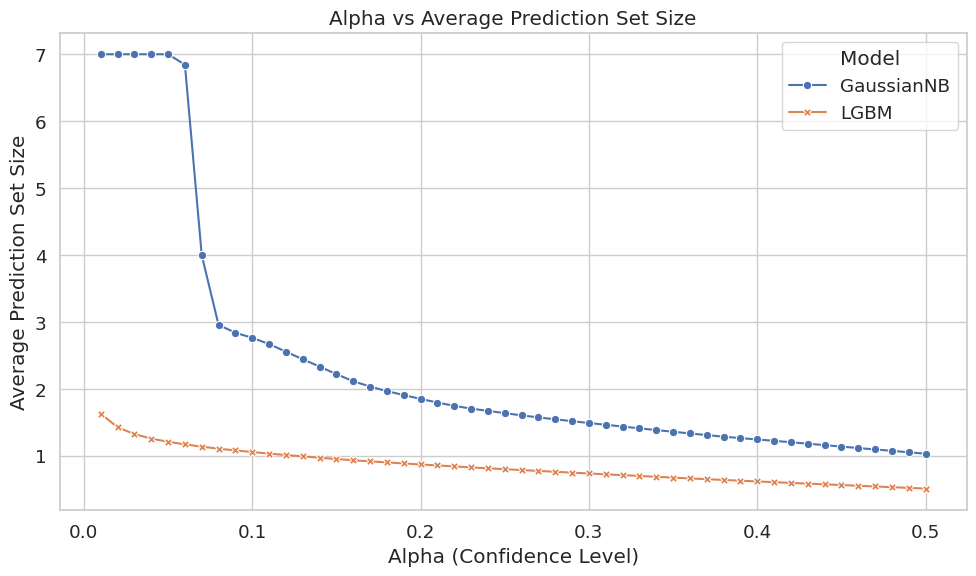

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert alpha to list in case it's a NumPy array
alpha_list = list(alpha)

# Build DataFrame for seaborn
df_gnb = pd.DataFrame({
    'Alpha': alpha_list,
    'Avg Prediction Set Size': widths_score_gnb,
    'Model': ['GaussianNB'] * len(alpha_list)
})

df_lgbm = pd.DataFrame({
    'Alpha': alpha_list,
    'Avg Prediction Set Size': widths_score_lgm,
    'Model': ['LGBM'] * len(alpha_list)
})

# Concatenate both DataFrames
df = pd.concat([df_gnb, df_lgbm], ignore_index=True)

# Plot using seaborn
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Alpha', y='Avg Prediction Set Size', hue='Model', style='Model', markers=True, dashes=False)

# Customize plot
plt.title('Alpha vs Average Prediction Set Size')
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Average Prediction Set Size')
plt.legend(title='Model')
plt.tight_layout()

# Save and show
plt.savefig("Images/avg_pred_set_size_vs_alpha.png", dpi=300)
plt.show()


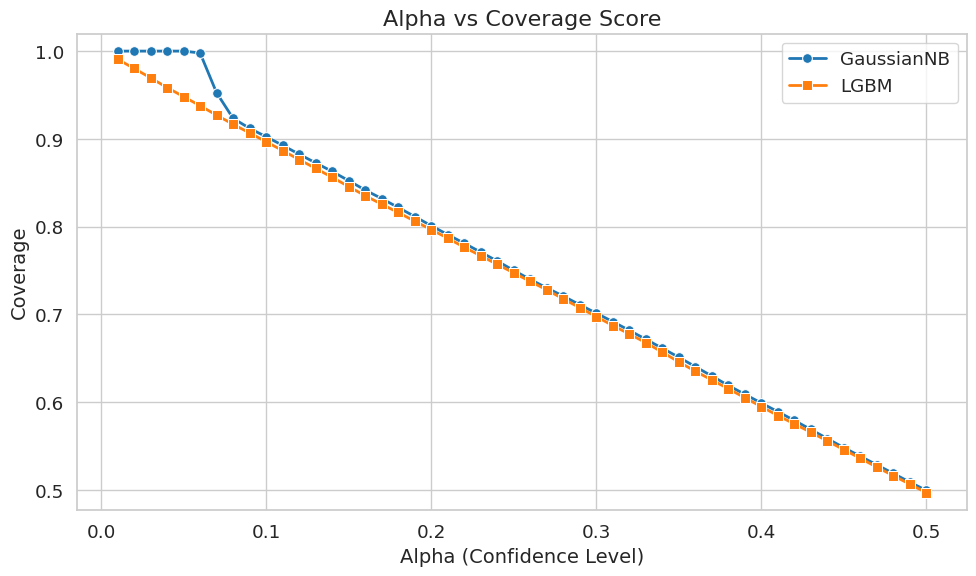

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure alpha and coverage scores are lists and the same length
alpha_list = list(alpha)
gnb_cover = list(coverages_score_gnb)
lgbm_cover = list(coverages_score_lgm)

assert len(alpha_list) == len(gnb_cover) == len(lgbm_cover), "Arrays must be the same length!"

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Adjust figure size for better scaling
plt.figure(figsize=(10, 6))  # Larger size for better visual clarity

# Plot with line styles and markers
sns.lineplot(x=alpha_list, y=gnb_cover, label='GaussianNB', marker='o', color='tab:blue', linewidth=2, markersize=7)
sns.lineplot(x=alpha_list, y=lgbm_cover, label='LGBM', marker='s', color='tab:orange', linewidth=2, markersize=7)

# Customize plot appearance
plt.title('Alpha vs Coverage Score', fontsize=16)
plt.xlabel('Alpha (Confidence Level)', fontsize=14)
plt.ylabel('Coverage', fontsize=14)

# Dynamically adjust the y-axis limits based on the data
y_min = min(min(gnb_cover), min(lgbm_cover)) - 0.02  # Add a bit of space below the min value
y_max = max(max(gnb_cover), max(lgbm_cover)) + 0.02  # Add a bit of space above the max value
plt.ylim(y_min, y_max)

# Add gridlines for better readability
plt.grid(True)

# Save the plot with higher DPI for better quality
plt.savefig("Images/coverage_score_vs_alpha.png", dpi=300)

# Show the plot
plt.tight_layout()
plt.show()


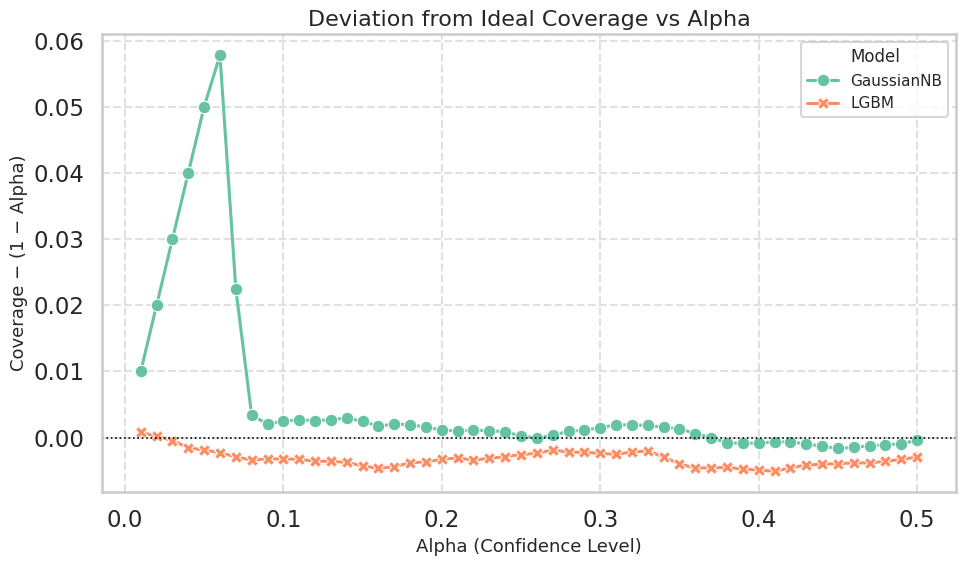

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute ideal coverage
ideal_coverage = [1 - x for x in alpha]

# Compute deviations
diff_gnb = [c - ic for c, ic in zip(coverages_score_gnb, ideal_coverage)]
diff_lgm = [c - ic for c, ic in zip(coverages_score_lgm, ideal_coverage)]

# Create tidy DataFrame
data = []

for a, d_gnb, d_lgm in zip(alpha, diff_gnb, diff_lgm):
    data.append({'Alpha': a, 'Deviation': d_gnb, 'Model': 'GaussianNB'})
    data.append({'Alpha': a, 'Deviation': d_lgm, 'Model': 'LGBM'})

df = pd.DataFrame(data)

# Set Seaborn style
sns.set(style="whitegrid", context="talk", palette="Set2")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Alpha',
    y='Deviation',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    linewidth=2.2
)

# Add horizontal line at 0
plt.axhline(0, color='black', linestyle=':', linewidth=1.2)

# Beautify
plt.title('Deviation from Ideal Coverage vs Alpha', fontsize=16)
plt.xlabel('Alpha (Confidence Level)', fontsize=13)
plt.ylabel('Coverage − (1 − Alpha)', fontsize=13)
plt.legend(title='Model', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

# Show
plt.savefig("Images/Split_conformal_Deviation from Ideal Coverage vs Alpha")
plt.show()


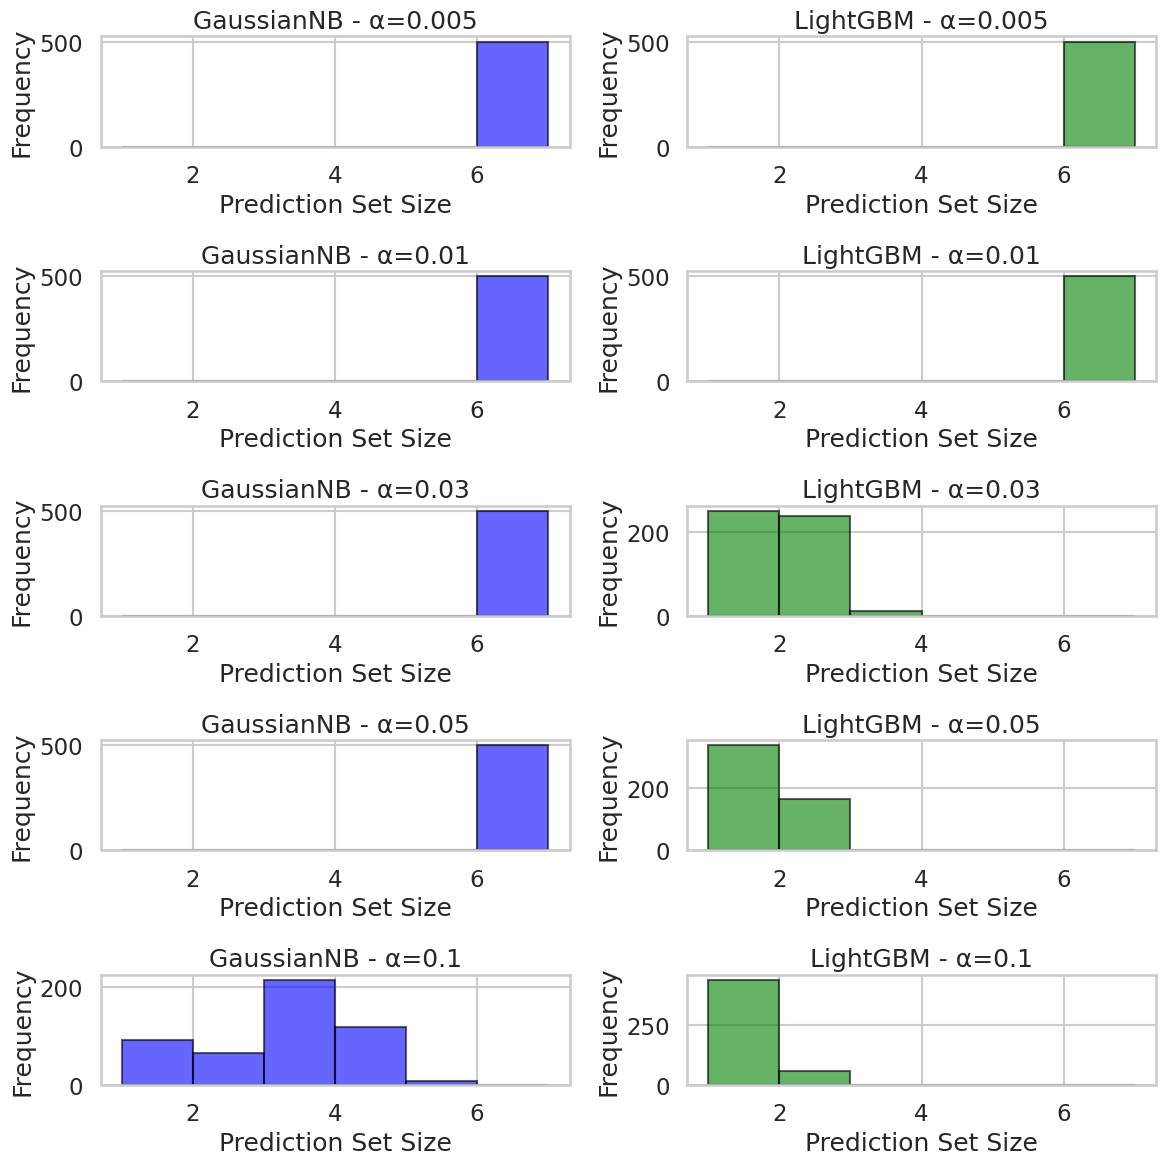

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Testing for various values of alpha
alpha_values = [0.005, 0.01, 0.03, 0.05, 0.1]

num_samples = 500

#train the models
#Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#LightGBM
lgbm_classifier = lgb.LGBMClassifier(
	objective='multiclass',
	boosting_type='gbdt',
	n_estimators=100,
	learning_rate=0.15,
	max_depth=10,
	device='gpu',
	gpu_use_dp=False,         # Use single precision (faster)
	num_class=len(set(y_train)),  # Set number of classes
	verbosity=-1
)

# Train the model
lgbm_classifier.fit(X_train, y_train)

mapie_gnb = MapieClassifier(estimator=gnb, method="lac", cv="prefit")
mapie_gnb.fit(X_calib, y_calib)
mapie_lgm = MapieClassifier(estimator=lgbm_classifier, method="lac", cv="prefit")
mapie_lgm.fit(X_calib, y_calib)

fig, axes = plt.subplots(len(alpha_values), 2, figsize=(12, 12))

for i, alpha_val in enumerate(alpha_values):
    # Predictions
    _, pred_set_gnb = mapie_gnb.predict(X_test, alpha=[alpha_val])
    _, pred_set_lgm = mapie_lgm.predict(X_test, alpha=[alpha_val])

    # Randomly sampling
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)

    # Compute set sizes
    set_sizes_gnb = [np.sum(pred_set_gnb[idx, :, 0]) for idx in random_indices]
    set_sizes_lgm = [np.sum(pred_set_lgm[idx, :, 0]) for idx in random_indices]

    # Plot GaussianNB histogram
    axes[i, 0].hist(set_sizes_gnb, bins=range(1, 8), alpha=0.6, color='blue', edgecolor='black')
    axes[i, 0].set_xlabel("Prediction Set Size")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].set_title(f"GaussianNB - α={alpha_val}")

    # Plot LightGBM histogram
    axes[i, 1].hist(set_sizes_lgm, bins=range(1, 8), alpha=0.6, color='green', edgecolor='black')
    axes[i, 1].set_xlabel("Prediction Set Size")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].set_title(f"LightGBM - α={alpha_val}")

plt.tight_layout()
plt.show()
